# Model Comparison (hourly data)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Check for GPU
import tensorflow as tf
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

if IN_COLAB:
    print("We're running Colab")
else:
    print(tf.config.list_physical_devices())
    print('\nCUDA GPU: ' + str(tf.test.is_gpu_available(cuda_only=True)))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

CUDA GPU: True


In [3]:
import pickle
from sklearn.model_selection import train_test_split

with open('./LSTM/cleaned_data.pkl', 'rb') as f:
    data = pickle.load(f)
    
train, test = train_test_split(data, test_size=0.2, shuffle = False)

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pickle

with open('./LSTM/models/hourly_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train = scaler.transform(train)
test = scaler.transform(test)

In [5]:
# load model
modelpath_list = ['./LSTM/models/LSTM-FC_16-4', './LSTM/models/LSTM-FC_24-6', 
                 './LSTM/models/LSTM-FC_32-8', './LSTM/models/LSTM-FC_40-10',
                 './LSTM/models/BiLSTM-FC_16-4', './LSTM/models/BiLSTM-FC_24-6', 
                 './LSTM/models/BiLSTM-FC_32-8', './LSTM/models/BiLSTM-FC_40-10']

predictions = dict()
mse = dict()

In [9]:
# start date for predictions
start_date = data.index[len(train) + 40]
start_index = len(data.loc[:start_date,:])
    
for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    # train period
    input_X = test[40 - input_len : 40, :-1]
    
    pred = scaler.data_range_[-1] * model.predict([input_X])[0] + scaler.data_min_[-1]
    predictions[model.name] = pred

In [10]:
#with open('./predictions.pkl', 'wb') as f:
#    pickle.dump(predictions, f)
    
with open('./predictions.pkl', 'rb') as f:
    pickle.load(f)

In [11]:
predictions

{'LSTM-FC_16-4': array([4.817768, 5.671547, 6.115719, 6.370617], dtype=float32),
 'LSTM-FC_24-6': array([4.71941  , 5.4472427, 6.041279 , 6.3733215, 6.301113 , 6.206688 ],
       dtype=float32),
 'LSTM-FC_32-8': array([4.98563  , 5.505356 , 6.0561104, 6.527611 , 6.8653793, 6.895096 ,
        6.58593  , 6.1298256], dtype=float32),
 'LSTM-FC_40-10': array([ 4.698265 ,  5.021282 ,  5.6765556,  6.436352 ,  7.4587097,
         8.339336 ,  9.307129 , 10.046917 , 10.486046 , 10.648392 ],
       dtype=float32),
 'BiLSTM-FC_16-4': array([4.5930862, 5.241806 , 5.440899 , 5.292    ], dtype=float32),
 'BiLSTM-FC_24-6': array([4.7444077, 5.4383545, 6.185028 , 6.810238 , 7.1711807, 7.358036 ],
       dtype=float32),
 'BiLSTM-FC_32-8': array([4.5504646, 5.019848 , 5.477974 , 5.7485123, 6.0046043, 6.238991 ,
        6.2067833, 6.0308876], dtype=float32),
 'BiLSTM-FC_40-10': array([3.6238708, 3.947937 , 4.283428 , 4.7323265, 5.192337 , 5.6032143,
        6.06065  , 6.2760353, 6.3877068, 6.3353004], dty

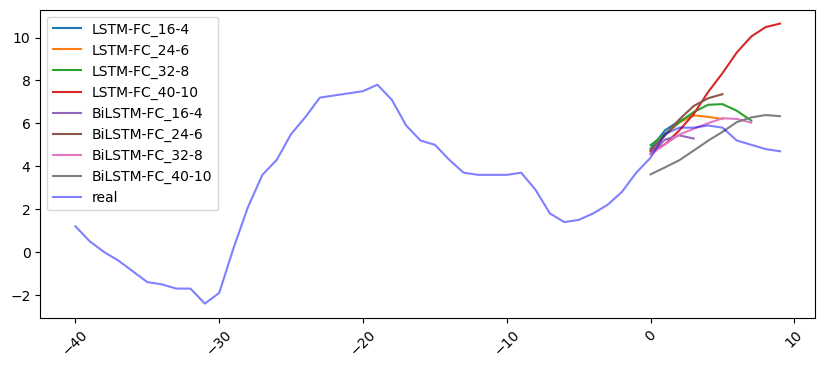

In [50]:
step = 40
real_output = scaler.data_range_[-1] * test[40 - step:50, -1] + scaler.data_min_[-1]
plt.figure(figsize=(10,4))
for key, pred in predictions.items():
    plt.plot(np.arange(0, len(pred)), pred, label = key)
plt.plot(np.arange(-step, 10),real_output, label = 'real', color = 'blue', alpha = 0.5)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [23]:
# splitting data into sequences
def split_sequences(features, target, seq_len, forecast_len):
    X,y = list(), list()
    for i in range(len(features)):
        end_input = i + seq_len
        end_predict = end_input + forecast_len
        if end_predict > len(features)-1:
            break
        seq_x, seq_y = features[i:end_input,:], target[end_input:end_predict]
        X.append(seq_x)
        y.append(seq_y)
    return tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(y, dtype=tf.float64)

In [27]:
from sklearn.metrics import mean_squared_error

for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    
    X_train, y_train = split_sequences(train[:,:-1], train[:,-1], seq_len =  input_len, forecast_len = output_len)
    X_test, y_test = split_sequences(test[:,:-1], test[:,-1],seq_len = input_len, forecast_len =  output_len)
    n_features = X_train.shape[2]
    
    y_hat_test = scaler.data_range_[-1] * model.predict(X_test) + scaler.data_min_[-1] 
    y_test = scaler.data_range_[-1] * y_test + scaler.data_min_[-1] 
    mse[model.name] = []
    for i in range(output_len):
        mse[model.name].append(mean_squared_error(y_test[:,i], y_hat_test[:,i]))

In [28]:
mse

{'LSTM-FC_16-4': [0.3468792358283327,
  1.385463301045007,
  2.5042893079614648,
  3.805967568581367],
 'LSTM-FC_24-6': [0.3623119132764649,
  1.1761292045913951,
  2.151656899878771,
  3.202648182702802,
  4.31434657408045,
  5.4605763810736265],
 'LSTM-FC_32-8': [0.40451281428843866,
  1.1988182964575063,
  2.1751686201568914,
  3.1773520820967467,
  4.325897649000036,
  5.544963949361725,
  6.630779089936803,
  7.764981379343154],
 'LSTM-FC_40-10': [0.6164566098554,
  1.4471739284652545,
  2.757198753567945,
  3.845028311271469,
  4.92930688147284,
  5.765062868334439,
  6.80090006048763,
  7.92484923829432,
  9.060814471802399,
  10.257733867825436],
 'BiLSTM-FC_16-4': [0.34521420320687884,
  1.2449387478649745,
  2.544374770298698,
  3.8792936964449907],
 'BiLSTM-FC_24-6': [0.34653820033948685,
  1.1739736387279696,
  2.204239202781417,
  3.3682310636248514,
  4.50925075756915,
  5.638017241519427],
 'BiLSTM-FC_32-8': [0.5862082773290601,
  1.4090336082469515,
  2.4192789751159594

In [29]:
with open('./mse.pkl', 'wb') as f:
    pickle.dump(mse, f)

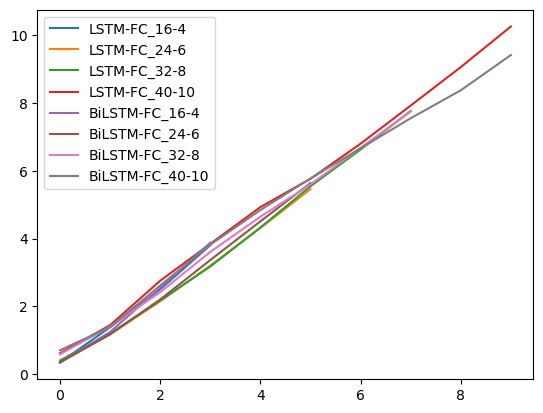

In [38]:
for key, item in mse.items():
    plt.plot(item, label = key)
plt.legend()
plt.show()

In [34]:
y_test[0,]

<tf.Tensor: shape=(10,), dtype=float64, numpy=array([4.4, 5.5, 5.8, 5.8, 5.9, 5.8, 5.2, 5. , 4.8, 4.7])>

In [52]:
mse_all = dict()

for path in modelpath_list:
    model = tf.keras.models.load_model(path)
    in_out = path.split('_')[-1]
    input_len = int(in_out.split('-')[0])
    output_len = int(in_out.split('-')[1])
    
    X_train, y_train = split_sequences(train[:,:-1], train[:,-1], seq_len =  input_len, forecast_len = output_len)
    X_test, y_test = split_sequences(test[:,:-1], test[:,-1],seq_len = input_len, forecast_len =  output_len)
    n_features = X_train.shape[2]
    
    y_hat_test = scaler.data_range_[-1] * model.predict(X_test) + scaler.data_min_[-1] 
    y_test = scaler.data_range_[-1] * y_test + scaler.data_min_[-1] 
    
    y_hat_train = scaler.data_range_[-1] * model.predict(X_train) + scaler.data_min_[-1] 
    y_train = scaler.data_range_[-1] * y_train + scaler.data_min_[-1] 
    
    mse_all[model.name] = [mean_squared_error(y_train, y_hat_train) , mean_squared_error(y_test, y_hat_test)]

In [53]:
with open('./mse_all.pkl', 'wb') as f:
    pickle.dump(mse_all, f)

In [54]:
mse_all

{'LSTM-FC_16-4': [1.8360869614599022, 2.0106498533540216],
 'LSTM-FC_24-6': [2.446576965488441, 2.7779448592671887],
 'LSTM-FC_32-8': [3.486195644458234, 3.902809235080084],
 'LSTM-FC_40-10': [4.666956123876718, 5.340452499137529],
 'BiLSTM-FC_16-4': [1.8283678609734062, 2.003455354453857],
 'BiLSTM-FC_24-6': [2.4629278074029464, 2.8733750174269796],
 'BiLSTM-FC_32-8': [3.438300935492914, 4.087145446688269],
 'BiLSTM-FC_40-10': [4.516943754604353, 5.115871769042711]}

In [58]:
mse_df = pd.DataFrame(mse_all).T

In [61]:
mse_df.columns = ['Train', 'Test']

In [62]:
mse_df

,Train,Test
LSTM-FC_16-4,1.836087,2.010650
LSTM-FC_24-6,2.446577,2.777945
LSTM-FC_32-8,3.486196,3.902809
LSTM-FC_40-10,4.666956,5.340452
BiLSTM-FC_16-4,1.828368,2.003455
BiLSTM-FC_24-6,2.462928,2.873375
BiLSTM-FC_32-8,3.438301,4.087145
BiLSTM-FC_40-10,4.516944,5.115872


In [68]:
print(mse_df.to_latex(index=True,  float_format="{:.4f}".format))

\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
LSTM-FC\_16-4    & 1.8361 & 2.0106 \\
LSTM-FC\_24-6    & 2.4466 & 2.7779 \\
LSTM-FC\_32-8    & 3.4862 & 3.9028 \\
LSTM-FC\_40-10   & 4.6670 & 5.3405 \\
BiLSTM-FC\_16-4  & 1.8284 & 2.0035 \\
BiLSTM-FC\_24-6  & 2.4629 & 2.8734 \\
BiLSTM-FC\_32-8  & 3.4383 & 4.0871 \\
BiLSTM-FC\_40-10 & 4.5169 & 5.1159 \\
\bottomrule
\end{tabular}

